# **AlexNet Location Recognition Model AI23-2**

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Directories + Parameters


Buat dimensi imagenya, ada yang pake 227x227 dan ada yang pake 224x224.

AlexNet sendiri terima input berapa aja sizenya selama itu masih at least 224 x 224

In [ ]:
train_dir = '/content/drive/MyDrive/ASLAB TPA WEB/Dataset/train'
test_dir = '/content/drive/MyDrive/ASLAB TPA WEB/Dataset/test'
val_dir = '/content/drive/MyDrive/ASLAB TPA WEB/Dataset/valid'

train_csv = pd.read_csv('/content/drive/MyDrive/ASLAB TPA WEB/Dataset/train/_classes.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/ASLAB TPA WEB/Dataset/test/_classes.csv')
val_csv = pd.read_csv('/content/drive/MyDrive/ASLAB TPA WEB/Dataset/valid/_classes.csv')

In [ ]:
img_h = 224
img_w = 224
EPOCHS = 30
BATCH_SIZE = 32

## Data Exploration

In [ ]:
print(list(train_csv.columns)[1:])

[' Brazil', ' Canada', ' Finland', ' Japan', ' United-Kingdom', ' United_States', ' Unlabeled']


In [ ]:
# remove whitespaces + change format
train_csv = train_csv.rename(columns=lambda x: x.strip().replace('United_States', 'United-States'))
test_csv = test_csv.rename(columns=lambda x: x.strip().replace('United_States', 'United-States'))
val_csv = val_csv.rename(columns=lambda x: x.strip().replace('United_States', 'United-States'))

In [ ]:
print(list(train_csv.columns)[1:])

['Brazil', 'Canada', 'Finland', 'Japan', 'United-Kingdom', 'United-States', 'Unlabeled']


In [ ]:
classes = list(train_csv.columns)[1:]

In [ ]:
train_csv.head()

,filename,Brazil,Canada,Finland,Japan,United-Kingdom,United-States,Unlabeled
0,canvas_1630049629_jpg.rf.9173ca80a66b0e0aa8b69...,1,0,0,0,0,0,0
1,60-61946-24-87396_jpg.rf.917936eddea98c4223b89...,0,0,1,0,0,0,0
2,canvas_1629307990_jpg.rf.9190555e23a965ec04131...,0,0,0,0,0,1,0
3,canvas_1629419207_jpg.rf.919b5ce1d4fac10e637b7...,0,0,0,1,0,0,0
4,canvas_1629825120_jpg.rf.91a363fc8d278b53a90d2...,0,0,0,0,1,0,0


In [ ]:
def get_labels(row):
  class_labels = classes

  for label in class_labels:
    if row[label] == 1:
      return label

  return 'Unknown'

In [ ]:
train_csv.columns[1:]

Index(['Brazil', 'Canada', 'Finland', 'Japan', 'United-Kingdom',
       'United-States', 'Unlabeled'],
      dtype='object')

In [ ]:
train_csv['class_labels'] = train_csv.apply(get_labels, axis=1)
test_csv['class_labels'] = test_csv.apply(get_labels, axis=1)
val_csv['class_labels'] = val_csv.apply(get_labels, axis=1)

In [ ]:
train_csv.drop(classes, axis=1, inplace=True)
test_csv.drop(classes, axis=1, inplace=True)
val_csv.drop(classes, axis=1, inplace=True)

In [ ]:
print(train_csv['class_labels'].unique())
print(test_csv['class_labels'].unique())
print(val_csv['class_labels'].unique())

['Brazil' 'Finland' 'United-States' 'Japan' 'United-Kingdom' 'Canada'
 'Unlabeled']
['United-Kingdom' 'Finland' 'United-States' 'Brazil' 'Japan' 'Canada']
['Brazil' 'United-States' 'Canada' 'United-Kingdom' 'Finland' 'Japan']


In [ ]:
print(train_csv['class_labels'].value_counts())

United-States     1051
Brazil            1050
Canada            1047
United-Kingdom    1043
Japan             1038
Finland           1002
Unlabeled            5
Name: class_labels, dtype: int64


nah ini yang Unlabeled gabakal dihilangin, tpi jdinya dimasukin ke dalem finland aja krn datanya paling dikit.

kenapa begitu? karena data itu berharga :D

ditambah dataset ini datanya terbatas kan, dan AlexNet architecture yang menang lombanya juga masih punya margin of error 15,3% (roughly)

In [ ]:
train_csv['class_labels'] = train_csv['class_labels'].replace('Unlabeled', 'Finland')

In [ ]:
print(train_csv['class_labels'].value_counts())

United-States     1051
Brazil            1050
Canada            1047
United-Kingdom    1043
Japan             1038
Finland           1007
Name: class_labels, dtype: int64


In [ ]:
train_csv.head()

,filename,class_labels
0,canvas_1630049629_jpg.rf.9173ca80a66b0e0aa8b69...,Brazil
1,60-61946-24-87396_jpg.rf.917936eddea98c4223b89...,Finland
2,canvas_1629307990_jpg.rf.9190555e23a965ec04131...,United-States
3,canvas_1629419207_jpg.rf.919b5ce1d4fac10e637b7...,Japan
4,canvas_1629825120_jpg.rf.91a363fc8d278b53a90d2...,United-Kingdom


In [ ]:
labels = train_csv['class_labels'].unique()
labels

array(['Brazil', 'Finland', 'United-States', 'Japan', 'United-Kingdom',
       'Canada'], dtype=object)

In [ ]:
num_classes = len(labels)
num_classes

6

## Preprocessing

disini datanya gw coba blur (sebelumnya engga)

In [ ]:
def preprocess_image(image):
    img = cv2.GaussianBlur(image, (5, 5), 0)
    return img

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1./255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255.0, preprocessing_function=preprocess_image)

val_datagen = ImageDataGenerator(rescale=1./255.0, preprocessing_function=preprocess_image)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
              dataframe=train_csv,
              directory=train_dir,
              x_col='filename',
              y_col='class_labels',
              target_size=(img_h, img_w),
              batch_size=BATCH_SIZE,
              shuffle=True,
              class_mode='categorical')

test_gen = test_datagen.flow_from_dataframe(
              dataframe=test_csv,
              directory=test_dir,
              x_col='filename',
              y_col='class_labels',
              target_size=(img_h, img_w),
              shuffle=False,
              class_mode='categorical')

val_gen = val_datagen.flow_from_dataframe(
              dataframe=val_csv,
              directory=val_dir,
              x_col='filename',
              y_col='class_labels',
              target_size=(img_h, img_w),
              batch_size=BATCH_SIZE,
              shuffle=True,
              class_mode='categorical')

Found 6145 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 91 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 815 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 79 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 1779 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
train_num = train_gen.samples
val_num = val_gen.samples

train_num, val_num

(6145, 1779)

## Alex Net Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

Ini base architecturenya diambil dri docs AlexNetnya, trus diganti"

In [ ]:
input_shape = (img_h, img_w, 3) #param ke-3 ini jumlah channel dri gambarnya
input_shape

(224, 224, 3)

In [ ]:
model = Sequential([
    # block 1
    Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="relu", input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"),

    # block 2
    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"),

    # block 3
    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"),

    # connected layers
    Flatten(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # output layer
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
opt = SGD(0.01)
loss = CategoricalCrossentropy()
metrics = [
    'accuracy',
    TopKCategoricalAccuracy(k=3, name='top_k_accuracy')
]

Disini akan dicoba menggunakan opotimizer SGD (bukan adam) dan buat metricsnya, disini akan ditambahkan Top 3 Accuracy. Jadi guessnya akan ditampilkan 3 teratas

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
model.output_shape

(None, 6)

Buat Training, seperti biasa bakal pake EarlyStop buat cegah underfitting ataupun overfitting

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=[early_stopping], batch_size=BATCH_SIZE)

Epoch 1/30
193/193 [==============================] - 2309s 12s/step - loss: 2.4301 - accuracy: 0.2254 - top_k_accuracy: 0.5841 - val_loss: 1.8457 - val_accuracy: 0.2119 - val_top_k_accuracy: 0.5880
Epoch 2/30
193/193 [==============================] - 2126s 11s/step - loss: 1.9624 - accuracy: 0.2755 - top_k_accuracy: 0.6503 - val_loss: 1.8653 - val_accuracy: 0.1956 - val_top_k_accuracy: 0.6633
Epoch 3/30
193/193 [==============================] - 2117s 11s/step - loss: 1.7609 - accuracy: 0.3113 - top_k_accuracy: 0.6908 - val_loss: 1.7178 - val_accuracy: 0.2996 - val_top_k_accuracy: 0.6942
Epoch 4/30
193/193 [==============================] - 2130s 11s/step - loss: 1.6359 - accuracy: 0.3577 - top_k_accuracy: 0.7209 - val_loss: 1.6207 - val_accuracy: 0.3345 - val_top_k_accuracy: 0.7195
Epoch 5/30
193/193 [==============================] - 2174s 11s/step - loss: 1.5744 - accuracy: 0.3686 - top_k_accuracy: 0.7481 - val_loss: 1.4715 - val_accuracy: 0.4295 - val_top_k_accuracy: 0.7819
Epoch

KeyboardInterrupt: 

In [ ]:
model.save('/content/drive/MyDrive/ASLAB TPA WEB/alexnet1.h5')
model.save_weights('/content/drive/MyDrive/ASLAB TPA WEB/alexnet_weight1.h5')

NameError: name 'history' is not defined

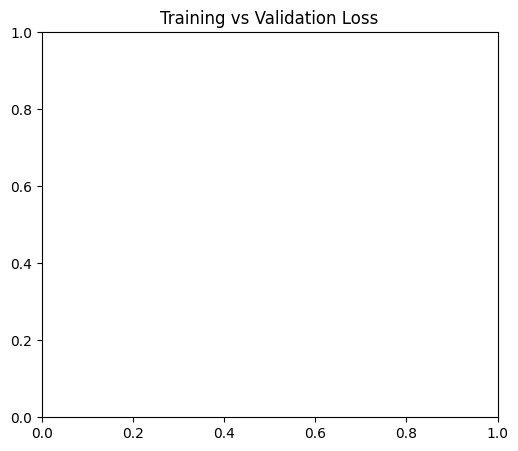

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Training vs Validation Loss')
plt.plot(history.history['loss'], label='training loss', color='lightblue', marker='o')
plt.plot(history.history['val_loss'], label='validation loss', color='orchid', marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Training vs Validation Accuracy')
plt.plot(history.history['accuracy'], label='training accuracy', color='lightblue', marker='o')
plt.plot(history.history['val_accuracy'], label='validation accuracy', color='orchid', marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Training vs Validation Top-K Accuracy')
plt.plot(history.history['top_k_accuracy'], label='training top-k accuracy', color='lightblue', marker='o')
plt.plot(history.history['val_top_k_accuracy'], label='validation top-k accuracy', color='orchid', marker='o')
plt.xlabel('epoch')
plt.ylabel('top-k accuracy')
plt.legend()

plt.show()

In [ ]:
test_batch = next(test_gen)
images = test_batch[0]

true_labels = test_batch[1].argmax(axis=1)

In [ ]:
res = model.evaluate(test_gen)

In [ ]:
preds = model.predict(images)

In [ ]:
predicted_labels = np.argmax(preds, axis=1)

In [ ]:
plt.figure(figsize=(16, 8))

for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.title(f"True: {classes[true_labels[i]]} \nPredicted: {classes[predicted_labels[i]]}")

plt.tight_layout(pad=1)
plt.show()

In [ ]:
top_k = 3
top_k_preds= np.argsort(preds, axis=1)[:, -top_k:][:, ::-1]
top_k_percent = np.sort(preds, axis=1)[:, -top_k:][:, ::-1]

In [ ]:
plt.figure(figsize=(16, 8))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    true_label = classes[true_labels[i]]
    pred_labels = classes[predicted_labels[i]]

    labels_with_percentages = [f"{classes[idx]}: {pred*100:.2f}%" for idx, pred in zip(top_k_preds[i], top_k_percent[i])]

    # title = f"True: {true_label}\nPredicted: {pred_labels}\nTop-{top_k} Predictions:\n" + "\n".join(labels_with_percentages)
    title = f"True: {true_label}\nTop-{top_k} Predictions:\n" + "\n".join(labels_with_percentages)

    plt.title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout(pad=1)
plt.show()